### <left> High-Dimensional Deep Learning - 5A
## <center>*Mini-project n° 2 – Conditional VAEs*</center>
### <center>2024-2025</center>
<div style="text-align: right;">
    <b>Project 2/4</b><br>
<div style="text-align: left;">
<b>Noms :</b> Maïmouna Gadji, Phuc-Luan Nguyen, Maddie Perez et Julia Soufflet<br>

### Objectif : 

L'objectif de ce projet est de définir et d'entraîner un auto-encodeur variationnel conditionnel (CVAE)

# I - Introduction aux VAE et CVAE

Une des premières étapes consiste à définir les CVAE et expliquer leurs différences avec les VAE, en appuyant nos explications sur des ressources fiables.

Voici quelques liens que nous avons trouvé utiles : 

https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f

https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html


## I.1 - Rappel sur les VAE 
Les **Variational Autoencoders (VAE)** sont un type de réseau d'autoencodeur probabiliste, capable de générer des nouvelles données en apprenant une représentation latente continue des données d'entrée. Le VAE se compose de deux parties principales :

- **Encodeur** : Il mappe l'entrée \( x \) vers une distribution latente, en produisant des paramètres (moyenne et écart-type) d'une distribution gaussienne dans un espace latent continu.
- **Décodeur** : À partir d'un point \( z \) tiré de cette distribution latente, il reconstruit une version approximative de l'entrée, notée \( x' \).

Une particularité des VAE réside dans leur **prior distribution** (ou distribution a priori) : il s'agit de la distribution souhaitée pour l'espace latent. Généralement, cette distribution a priori est une gaussienne standard $ \mathcal{N}(0, 1) $, ce qui impose une structure particulière sur l'espace latent. En encourageant l'espace latent à suivre cette distribution gaussienne, le VAE est capable de générer des nouvelles données en tirant des échantillons aléatoires de l'espace latent et en les passant dans le décodeur.


Le processus de génération d'une nouvelle donnée implique donc de sélectionner aléatoirement un vecteur latent \( z \) selon la distribution apprise par l'encodeur. Ensuite, ce \( z \) est passé dans le décodeur pour obtenir une reconstruction. Cela permet de créer des nouvelles instances qui suivent les caractéristiques générales des données d'entraînement.

Le VAE utilise une fonction de perte composée de deux termes principaux :
1. **Reconstruction loss** : Mesure la différence entre l'entrée d'origine \( x \) et la reconstruction \( x' \), permettant de minimiser la perte d'information.
2. **KL Divergence** : Régularise la distribution latente pour qu'elle suive une distribution normale standard $ \mathcal{N}(0, 1) $, assurant la continuité et la généralisation dans l'espace latent.


**Problème des VAE :** Bien que les VAE soient capables de générer de nouvelles instances, ils ne permettent pas d’imposer des conditions spécifiques (par exemple, générer une image d'une catégorie donnée comme une chaussure ou un pull). C'est cela qui nous amène à étudier les CVAE.

## I.2 - Définition CVAE

Les **Conditional Variational Autoencoders (CVAE)** représentent une extension des VAE qui permettent de conditionner la génération sur une information supplémentaire, comme une classe ou un label. Le CVAE ajoute ainsi une contrainte à la génération de données, ce qui permet de contrôler le type de données générées.

## I.3 - Différences entre VAE et CVAE

Dans un VAE, pour générer une nouvelle observation \( x \), on sélectionne un \( z \) à partir de la distribution latente, puis le décodeur génère l'image correspondante \( x \). La classe de l’image générée est donc imprévisible. 

Dans les CVAE, la **distribution a priori** dépend également du label \( y \). En d'autres termes, pour chaque classe \( y \), on a une distribution a priori conditionnelle \( p(z | y) \). Cette approche permet de réguler l'espace latent en fonction des classes, rendant possible la génération d'exemples d'une classe spécifique. 

Avec un CVAE, la génération devient conditionnelle. Concrètement :
- L'encodeur reçoit en entrée l'image \( x \) ainsi que son label \( y \), et génère une distribution latente \( p(z | y) \).
- Lors de la génération, on choisit d'abord le label souhaité \( y \), puis on tire un vecteur latent \( z \) selon la distribution conditionnelle \( p(z | y) \).
- Enfin, le décodeur utilise ce \( z \) et le label \( y \) pour générer l'image conditionnée \( x' \), suivant la distribution \( p(x | z, y) \).

Cette architecture permet de générer des données spécifiques à une catégorie choisie, ce qui est particulièrement utile dans des applications où le contrôle sur le type de données générées est nécessaire (comme demandé dans le projet avec les catégories du dataset Fashion-MNIST, pour générer des images selon des labels précis).



# II - Entraîner un CVAE sur Fashion-MNIST 
Dans cette section, nous allons présenter le choix de l'architecture, des hyperparamètres et de la fonction de perte utilisés pour entraîner un **Conditional Variational Autoencoder (CVAE)** sur le dataset Fashion-MNIST. 

## II.1 - Chargement des données

Pour ce projet, nous utilisons le dataset **Fashion-MNIST**, composé d'images en niveaux de gris de vêtements classés en 10 catégories (T-shirt/top, Pantalon, Pull, etc.). Le chargement des données est effectué via `torchvision.datasets`.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

fashion_mnist_labels = [
    "T-shirt/top",
    "Pants",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


## II.2 - Visualisation des données

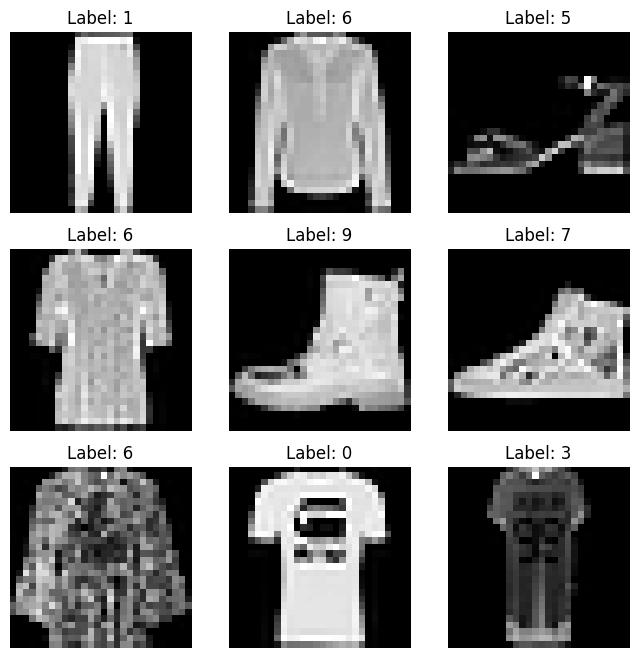

Différents labels :  [0 1 2 3 4 5 6 7 8 9]
Nombre de classes : 10


In [3]:
# Plot 9 random images de fashion MNIST
def plot_images(img_dataset):
    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)
print("Différents labels : ",np.unique(train_dataset.targets[:]))
num_classes = np.size(np.unique(train_dataset.targets[:]))
print("Nombre de classes :", num_classes)

## II.3 - Choix de l'Architecture

L'architecture du **Conditional Variational Autoencoder (CVAE)** pour ce projet repose sur un modèle convolutif permettant de capturer les caractéristiques visuelles des images Fashion-MNIST. Voici les choix architecturaux que nous avons faits et leurs justifications :

- **Encodeur** : 
    - L'encodeur utilise des couches de convolution pour extraire les caractéristiques des images. Les couches convolutionnelles réduisent progressivement la taille des images d'entrée tout en augmentant le nombre de canaux de sortie, permettant au modèle de capturer des détails de plus en plus complexes.
    - Nous ajoutons des couches de normalisation (**BatchNorm**)  (cela permet de stabiliser l’entraînement et d’accélérer la convergence) et des fonctions d'activation **ReLU** pour introduire de la non-linéarité (ce qui permet au modèle d’apprendre des relations complexes dans les données). 
    - Les convolutions utilisent des tailles de kernel de 3x3 et 4x4 pour capter des détails plus fins dans les images.
    - Le label de la classe \( y \) est intégré en concaténant \( y \) avec le vecteur latente en sortie des convolutions avant les couches entièrement connectées (`fc_mu` et `fc_logvar`).
      
      
Formule pour le calcul des dimensions de sortie pour Conv2d: $\text{Sortie} = \left\lfloor \frac{\text{Entrée} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1$

- **Espace latent** :
    - Le modèle génère un vecteur latent \( z \) à partir de la **moyenne** (`mu`) et de la **log-variance** (`logvar`) des données encodées (reparametrization trick). Ce vecteur est ensuite concaténé avec le label \( y \) pour le passage dans le décodeur.

- **Décodeur** :
    - Le décodeur utilise des **convolutions transposées** pour reconstruire les images d'entrée. Ces couches permettent d'augmenter la taille des cartes de caractéristiques tout en réduisant le nombre de canaux, inversant ainsi le processus de l'encodeur.
    - La dernière couche applique une activation **Sigmoid** pour s'assurer que les sorties sont entre 0 et 1, en cohérence avec les valeurs des pixels des images en niveaux de gris de Fashion-MNIST.
    
Cette architecture permet de conditionner efficacement le processus de génération d'images sur les labels de classe, tout en capturant des détails fins grâce aux convolutions.


In [47]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4) + kernel_size = 3 : capturer des détails plus fins
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4+ num_classes, latent_dim)  #pour forcer à avor des valeurs positives, on prend le log de var et non pas var
        self.fc_decode = nn.Linear(latent_dim+ num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    #concatenation de x et y
    def encode(self, x, y):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat((x,y), dim = 1) # Concatenate and flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar): # reparametrization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
     #concatenation de z et y
    def decode(self, z, y):
        z = torch.cat((z,y), dim = 1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x
        
    #ajout de y en argument
    def forward(self, x, y):
        mu, logvar = self.encode(x,y)
        z = self.sample(mu, logvar)
        return self.decode(z,y), mu, logvar

## II.4 - Choix de la Fonction de Perte

Les CVAE utilisent une fonction de perte similaire aux VAE avec :
1. Une **reconstruction loss** qui évalue la qualité de la reconstruction en comparant \( x \) et \( x' \). Calculée avec la Binary Cross Entropy (`BCE`) entre l'image originale et l'image reconstruite, pour capturer les détails en niveaux de gris. 
2. Une **KL divergence** qui régularise la distribution latente conditionnelle \( p(z | y) \) pour la rapprocher de la distribution a priori $ \mathcal{N}(0, 1) $.

L'hyperparamètre `beta` régule l'importance de la KL divergence par rapport à la reconstruction.

La pondération de la KL divergence est cruciale pour assurer un bon équilibre entre la diversité des données générées et la précision des reconstructions. Ajuster ces termes dans la loss function est essentiel pour atteindre une bonne performance du modèle.
Source : https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html et cours VAE slide 35

In [48]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') #terme de reconstruction (noir et blanc contraste sinon mse)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #envoyer sur une loi normale
    return BCE + beta * KLD

## II.5 - Choix des Hyperparamètres et modèle choisi

Dans cette section, nous définissons les **hyperparamètres** et le processus d’entraînement de notre modèle sur le dataset Fashion-MNIST. Voici les détails de chaque paramètre et leur rôle dans l'apprentissage du modèle. Ci-après le modèle qui nous a donné la perte la plus faible, nos différents essais seront présentés par la suite. 

- **`batch_size`** : Nombre d'exemples utilisés dans chaque batch pour l'entraînement. Ici, `batch_size = 128`, ce qui offre un bon compromis entre efficacité de calcul et stabilité des gradients.
  
- **`latent_dim`** : Dimension de l’espace latent du modèle. Un espace latent de `latent_dim = 20` permet de capturer une représentation suffisamment riche des caractéristiques des images tout en évitant un surdimensionnement, qui pourrait entraîner des reconstructions de mauvaise qualité.

- **`learning_rate`** : Taux d'apprentissage pour l'optimisation du modèle. Une valeur de `1e-3` est souvent un bon point de départ pour stabiliser les mises à jour des poids. Il faudra cependant faire attention à éviter les oscillations de la loss lorsqu'on l'ajustera.

- **`epochs`** : Nombre d'epochs (cycles complets sur l’ensemble des données d’entraînement). Pour le meilleur modèle nous avons fixé `epochs = 150`. En fixant `epochs = 30` dans nos différents tests, nous espérons que le modèle ait suffisamment d’itérations pour apprendre les représentations latentes tout en minimisant le surapprentissage. On a pris 30 pour permettre une convergence suffisante du modèle tout en ne prenant pas trop de temps.

- **`beta`** : Coefficient pour la pondération de la **KL Divergence** dans la fonction de perte. Ici, `beta = 1`, ce qui équilibre les termes de reconstruction et de régularisation. Ajuster ce paramètre pourrait améliorer l’entraînement en réduisant la perte de reconstruction sans trop restreindre l’espace latent.

Pour plus d’informations sur le choix des hyperparamètres : https://www.linkedin.com/advice/1/how-can-you-choose-right-hyperparameters-qtifc .

In [51]:
# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
epochs = 150
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
#pour mettre à jour les paramètres du modèle avec un taux d’apprentissage défini, on utilise l'optimiseur Adam
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
av_loss_l = []

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

    av_loss_l.append(epoch_loss)

Epoch 1, Training loss: 268.1934
Epoch 2, Training loss: 245.3325
Epoch 3, Training loss: 242.4026
Epoch 4, Training loss: 240.6812
Epoch 5, Training loss: 239.5571
Epoch 6, Training loss: 238.6243
Epoch 7, Training loss: 238.0017
Epoch 8, Training loss: 237.3837
Epoch 9, Training loss: 236.9519
Epoch 10, Training loss: 236.6045
Epoch 11, Training loss: 236.2261
Epoch 12, Training loss: 235.9717
Epoch 13, Training loss: 235.7070
Epoch 14, Training loss: 235.5424
Epoch 15, Training loss: 235.2668
Epoch 16, Training loss: 235.1187
Epoch 17, Training loss: 234.9526
Epoch 18, Training loss: 234.8315
Epoch 19, Training loss: 234.6529
Epoch 20, Training loss: 234.4598
Epoch 21, Training loss: 234.3665
Epoch 22, Training loss: 234.3088
Epoch 23, Training loss: 234.1156
Epoch 24, Training loss: 234.0217
Epoch 25, Training loss: 233.9615
Epoch 26, Training loss: 233.8458
Epoch 27, Training loss: 233.7589
Epoch 28, Training loss: 233.7156
Epoch 29, Training loss: 233.6951
Epoch 30, Training loss

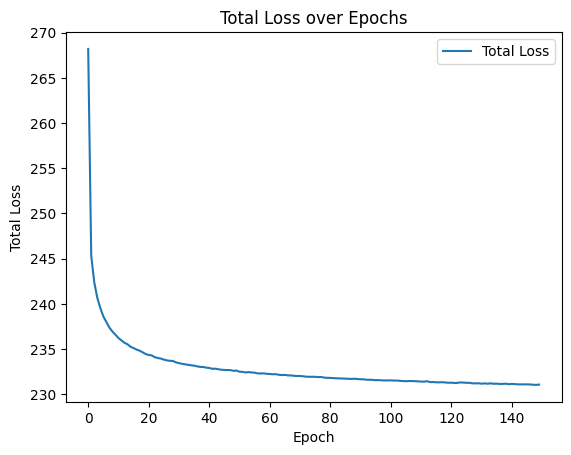

In [52]:
plt.plot(av_loss_l, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title(f'Total Loss over Epochs')
plt.legend()
plt.show()

**Interprétation des Résultats :**

On peut voir une diminution progressive de la perte à chaque époque, ce qui indique que le modèle parvient à optimiser sa reconstruction tout en régularisant l’espace latent.

- **Stabilisation de la perte** : À partir de l’époque 20, la perte tend à se stabiliser autour de 233, ce qui pourrait indiquer une convergence de l’entraînement. Cela signifie que le modèle a atteint un bon équilibre entre précision de la reconstruction et régularisation, et il peut générer des images plausibles à partir de l’espace latent conditionnel. Dans ce cas optimal nous avons augmenté le nombre d'epochs pour voir jusqu'à où la loss pouvait diminuer, nous sommes descendus à 231.

- **Tendance de la courbe de perte** : La diminution constante de la perte au fil des époques montre que l’apprentissage progresse sans oscillations majeures, suggérant que le taux d’apprentissage et la pondération de la KL Divergence (beta) sont bien choisis. Cependant, un affinement de beta pourrait améliorer légèrement la qualité de la reconstruction sans sacrifier la diversité des données générées.

## II.6 - Différents essais de calibration des paramètres

### II.6.1 Batch_Size*2

In [8]:
# Hyperparameters
batch_size = 256
latent_dim = 20
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 271.9590
Epoch 2, Training loss: 245.5892
Epoch 3, Training loss: 242.4243
Epoch 4, Training loss: 240.6741
Epoch 5, Training loss: 239.5608
Epoch 6, Training loss: 238.6226
Epoch 7, Training loss: 238.0372
Epoch 8, Training loss: 237.4237
Epoch 9, Training loss: 236.9390
Epoch 10, Training loss: 236.5857
Epoch 11, Training loss: 236.3340
Epoch 12, Training loss: 235.9922
Epoch 13, Training loss: 235.7800
Epoch 14, Training loss: 235.5353
Epoch 15, Training loss: 235.3429
Epoch 16, Training loss: 235.1563
Epoch 17, Training loss: 234.9432
Epoch 18, Training loss: 234.8320
Epoch 19, Training loss: 234.6618
Epoch 20, Training loss: 234.5858
Epoch 21, Training loss: 234.4180
Epoch 22, Training loss: 234.3424
Epoch 23, Training loss: 234.2347
Epoch 24, Training loss: 234.1533
Epoch 25, Training loss: 233.9899
Epoch 26, Training loss: 233.9478
Epoch 27, Training loss: 233.8534
Epoch 28, Training loss: 233.7775
Epoch 29, Training loss: 233.7503
Epoch 30, Training loss

### II.6.2 Batch_Size/2

In [17]:
# Hyperparameters
batch_size = 64
latent_dim = 20
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 265.2238
Epoch 2, Training loss: 245.0849
Epoch 3, Training loss: 242.1045
Epoch 4, Training loss: 240.4793
Epoch 5, Training loss: 239.3735
Epoch 6, Training loss: 238.5461
Epoch 7, Training loss: 237.8353
Epoch 8, Training loss: 237.3543
Epoch 9, Training loss: 236.8306
Epoch 10, Training loss: 236.4959
Epoch 11, Training loss: 236.2154
Epoch 12, Training loss: 235.8747
Epoch 13, Training loss: 235.6911
Epoch 14, Training loss: 235.4171
Epoch 15, Training loss: 235.1802
Epoch 16, Training loss: 235.0798
Epoch 17, Training loss: 234.8600
Epoch 18, Training loss: 234.6989
Epoch 19, Training loss: 234.5517
Epoch 20, Training loss: 234.4767
Epoch 21, Training loss: 234.3407
Epoch 22, Training loss: 234.2253
Epoch 23, Training loss: 234.1441
Epoch 24, Training loss: 233.9984
Epoch 25, Training loss: 233.9599
Epoch 26, Training loss: 233.8202
Epoch 27, Training loss: 233.7398
Epoch 28, Training loss: 233.6664
Epoch 29, Training loss: 233.5596
Epoch 30, Training loss

### II.6.3 Learning Rate = 1e-2

In [11]:
# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-2
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 301.9652
Epoch 2, Training loss: 249.9751
Epoch 3, Training loss: 245.8794
Epoch 4, Training loss: 243.2204
Epoch 5, Training loss: 241.7631
Epoch 6, Training loss: 240.6018
Epoch 7, Training loss: 239.4047
Epoch 8, Training loss: 238.8077
Epoch 9, Training loss: 238.0543
Epoch 10, Training loss: 237.8138
Epoch 11, Training loss: 237.5132
Epoch 12, Training loss: 237.1313
Epoch 13, Training loss: 236.8254
Epoch 14, Training loss: 236.7704
Epoch 15, Training loss: 236.4269
Epoch 16, Training loss: 236.2672
Epoch 17, Training loss: 236.1685
Epoch 18, Training loss: 235.9382
Epoch 19, Training loss: 235.7323
Epoch 20, Training loss: 235.6966
Epoch 21, Training loss: 235.6095
Epoch 22, Training loss: 235.3305
Epoch 23, Training loss: 235.3440
Epoch 24, Training loss: 235.1763
Epoch 25, Training loss: 235.0891
Epoch 26, Training loss: 234.9146
Epoch 27, Training loss: 234.8427
Epoch 28, Training loss: 234.7409
Epoch 29, Training loss: 234.7254
Epoch 30, Training loss

### II.6.4 Learning Rate = 1e-1

In [18]:
# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-1
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [96,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [97,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [98,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [99,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [100,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [101,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [66,0,0], thread: [102,0,0] Assertion `input_val >= zero && input_va

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Avec un learning rate de 1e-1, l'algorithme diverge ce qui génère une erreur. Cette valeur pas n'est pas adaptée au problème.

### II.6.5 Latent dim = 2

In [19]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 273.7148
Epoch 2, Training loss: 257.5045
Epoch 3, Training loss: 256.0830
Epoch 4, Training loss: 255.1790
Epoch 5, Training loss: 254.4064
Epoch 6, Training loss: 254.1153
Epoch 7, Training loss: 253.5944
Epoch 8, Training loss: 253.3355
Epoch 9, Training loss: 253.0180
Epoch 10, Training loss: 252.6282
Epoch 11, Training loss: 252.5192
Epoch 12, Training loss: 252.2095
Epoch 13, Training loss: 252.0450
Epoch 14, Training loss: 251.8782
Epoch 15, Training loss: 251.7673
Epoch 16, Training loss: 251.5180
Epoch 17, Training loss: 251.4387
Epoch 18, Training loss: 251.2594
Epoch 19, Training loss: 251.0961
Epoch 20, Training loss: 251.0524
Epoch 21, Training loss: 250.8727
Epoch 22, Training loss: 250.7470
Epoch 23, Training loss: 250.6840
Epoch 24, Training loss: 250.5275
Epoch 25, Training loss: 250.4268
Epoch 26, Training loss: 250.3847
Epoch 27, Training loss: 250.2441
Epoch 28, Training loss: 250.1114
Epoch 29, Training loss: 250.0820
Epoch 30, Training loss

# III - Comparaison d'un échantillon d'images avec leurs reconstructions

Original labels shape: torch.Size([128]), Attendu : 128
One-hot labels shape: torch.Size([128, 10]), Attendu : ((128, 10))


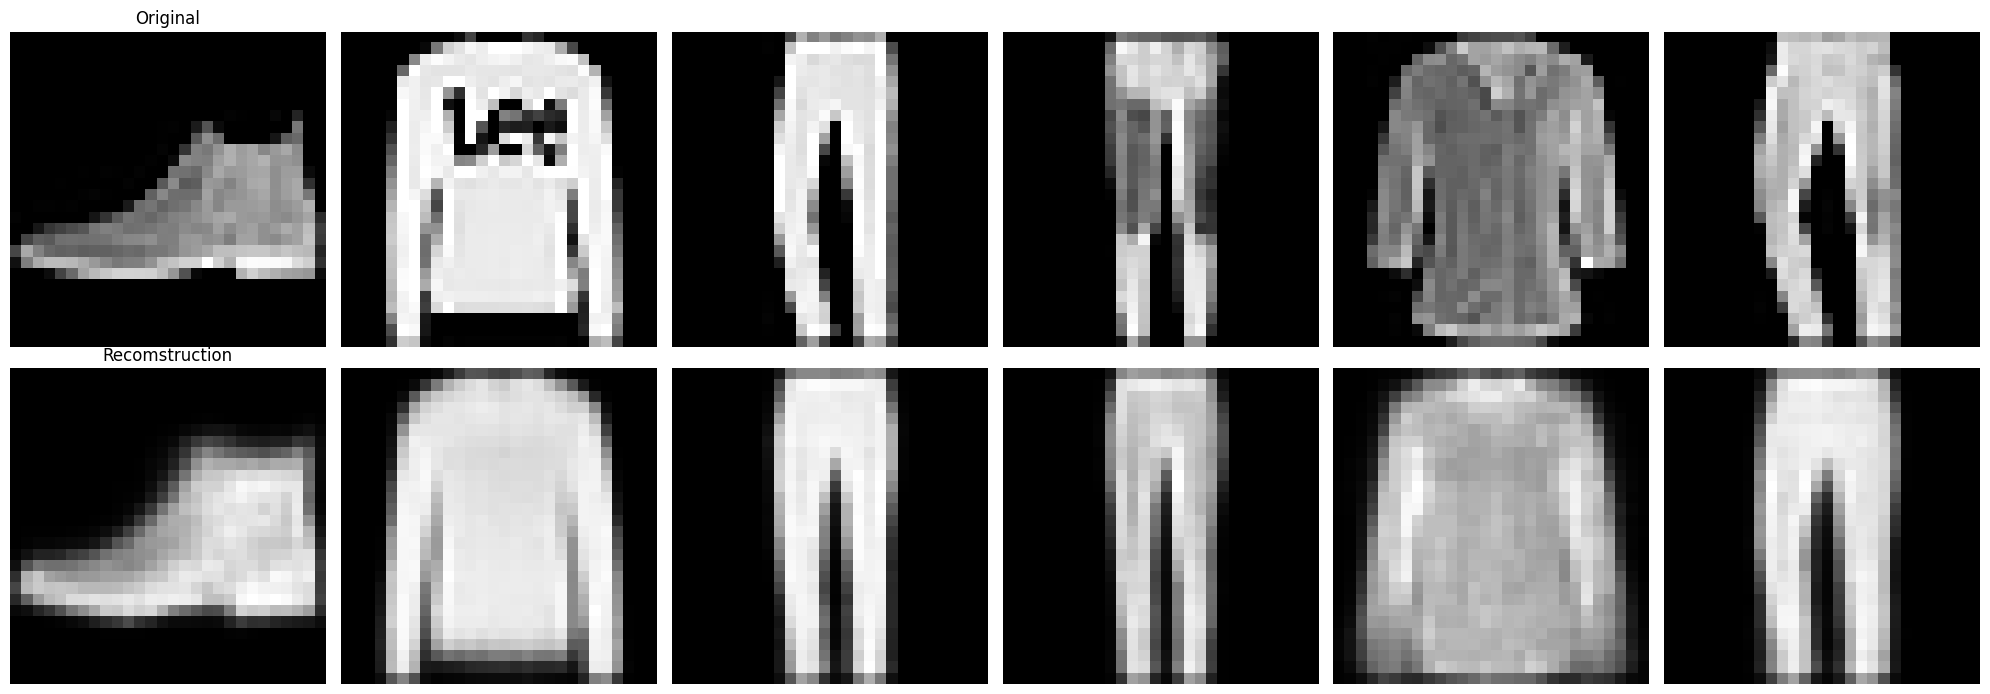

Ankle boot
Pullover
Pants
Pants
Shirt
Pants


In [21]:
# TODO: Define or import the image_comparison function
from utils import image_comparison 
# Select a batch of images from the test dataset
random_images = next(iter(test_loader))
# Vérifier la forme des étiquettes
labels = random_images[1]
print(f"Original labels shape: {labels.shape}, Attendu : {batch_size}")

# Convertir les étiquettes en one-hot si ce n'est pas déjà fait
if len(labels.shape) == 1:  # Vérifie si c'est un vecteur
    labels_one_hot = F.one_hot(labels, num_classes=10)  # Convertir en one-hot
else:
    labels_one_hot = labels  # Si déjà en one-hot

print(f"One-hot labels shape: {labels_one_hot.shape}, Attendu : ({batch_size, num_classes})")  # Devrait être (batch_size, 10)

# Passer les données au modèle
recons, _, _ = cvae(random_images[0].to(device), labels_one_hot.to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

    
labels = labels[:6]
for i in labels:
    print(fashion_mnist_labels[i])
labels_one_hot = labels_one_hot[:10,:]

Bien que les images reconstruites ne soient pas identiques aux images de départ, leurs traits qui permettent de les distinguer des autres labels ont été conservés. Cela signifie que le modèle a su capturer les détails caractéristiques de chaque catégorie. 

Les reconstructions des trois pants étant très similaires les unes des autres, ce qui peut interroger sur la fléxibilité de son espace latent : on veut en effet éviter qu'il soit trop restrictif. Nous verrons toutefois par la suite, avec la génération des échantillons, qu'il est en réalité capable de capturer la variabilité dans chaque classe et donc de générer des images d'une même classe différentes les unes des autres.

# IV - Visualisation des espaces latents et des résultats

In [12]:
# Rewrite loss function to return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 274.7609, BCE: 269.7332, KLD: 5.0276
Epoch 2: Average Loss: 257.4612, BCE: 252.4113, KLD: 5.0499
Epoch 3: Average Loss: 255.8704, BCE: 250.8533, KLD: 5.0171
Epoch 4: Average Loss: 255.0195, BCE: 250.0145, KLD: 5.0050
Epoch 5: Average Loss: 254.3554, BCE: 249.3750, KLD: 4.9804
Epoch 6: Average Loss: 254.0526, BCE: 249.1042, KLD: 4.9484
Epoch 7: Average Loss: 253.5070, BCE: 248.5824, KLD: 4.9247
Epoch 8: Average Loss: 253.1362, BCE: 248.2357, KLD: 4.9005
Epoch 9: Average Loss: 252.8817, BCE: 247.9937, KLD: 4.8880
Epoch 10: Average Loss: 252.5587, BCE: 247.6791, KLD: 4.8796


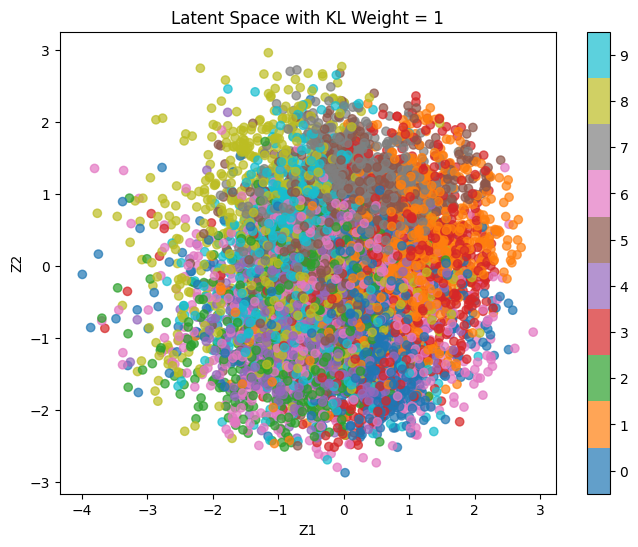

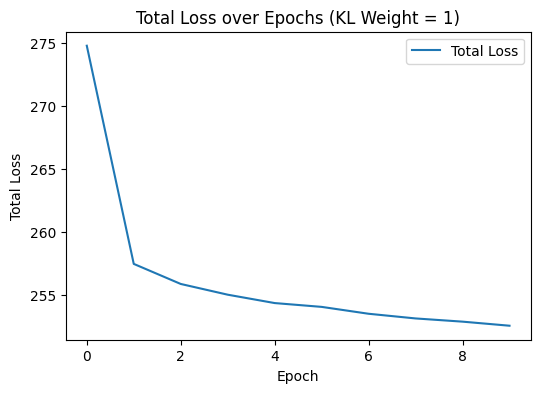

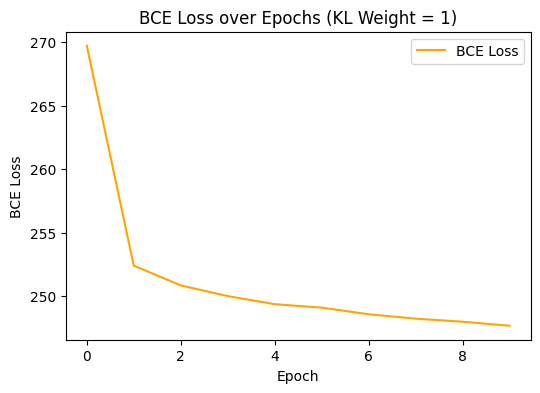

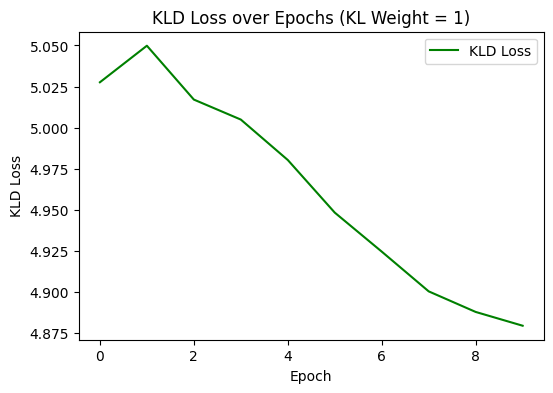


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 302.4750, BCE: 287.4055, KLD: 1.5070
Epoch 2: Average Loss: 283.6652, BCE: 266.9673, KLD: 1.6698
Epoch 3: Average Loss: 281.6494, BCE: 264.5837, KLD: 1.7066
Epoch 4: Average Loss: 280.5560, BCE: 263.3714, KLD: 1.7185
Epoch 5: Average Loss: 279.7289, BCE: 262.3839, KLD: 1.7345
Epoch 6: Average Loss: 279.3663, BCE: 261.9131, KLD: 1.7453
Epoch 7: Average Loss: 278.8023, BCE: 261.3344, KLD: 1.7468
Epoch 8: Average Loss: 278.5808, BCE: 260.8956, KLD: 1.7685
Epoch 9: Average Loss: 278.4082, BCE: 260.7378, KLD: 1.7670
Epoch 10: Average Loss: 278.1007, BCE: 260.3983, KLD: 1.7702


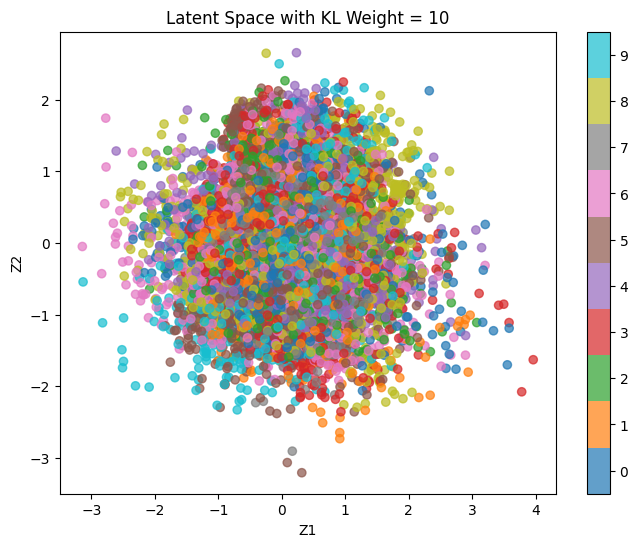

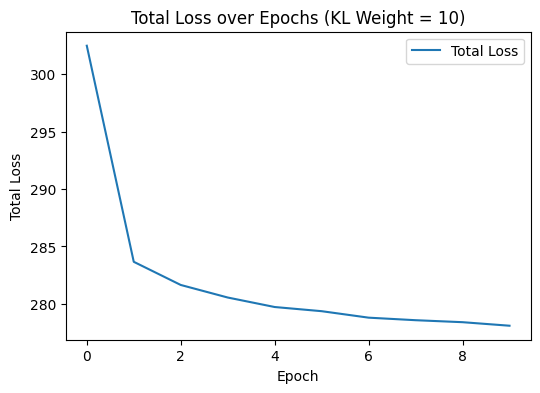

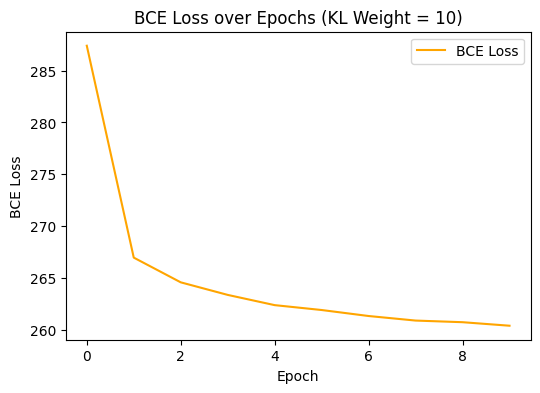

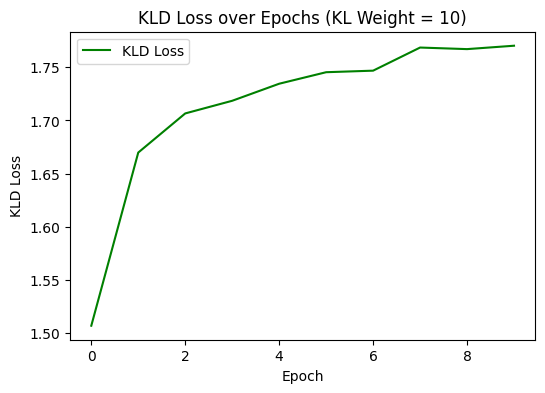


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 320.9162, BCE: 319.2498, KLD: 0.0167
Epoch 2: Average Loss: 308.0194, BCE: 307.9053, KLD: 0.0011
Epoch 3: Average Loss: 307.7584, BCE: 307.6683, KLD: 0.0009
Epoch 4: Average Loss: 307.6865, BCE: 307.6085, KLD: 0.0008
Epoch 5: Average Loss: 307.6995, BCE: 307.5921, KLD: 0.0011
Epoch 6: Average Loss: 307.5596, BCE: 307.4707, KLD: 0.0009
Epoch 7: Average Loss: 307.5400, BCE: 307.4589, KLD: 0.0008
Epoch 8: Average Loss: 307.4818, BCE: 307.4008, KLD: 0.0008
Epoch 9: Average Loss: 307.5019, BCE: 307.4338, KLD: 0.0007
Epoch 10: Average Loss: 307.4833, BCE: 307.4196, KLD: 0.0006


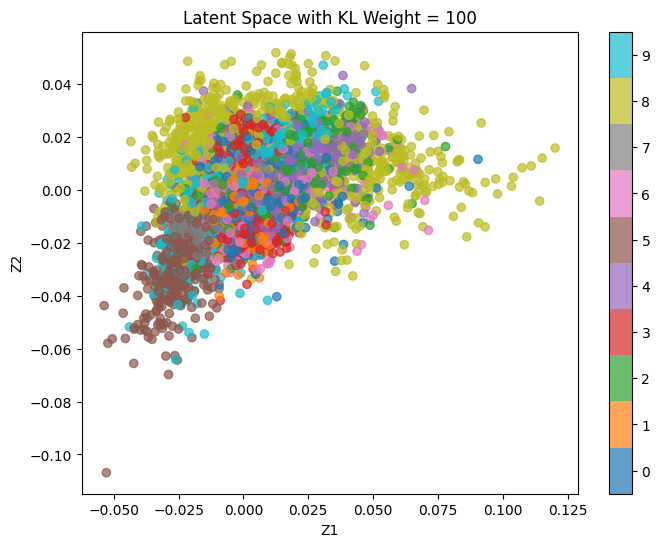

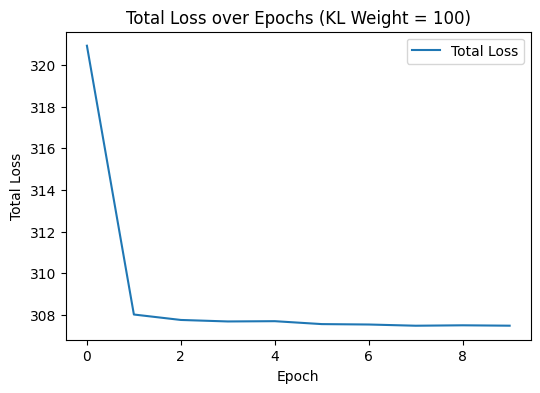

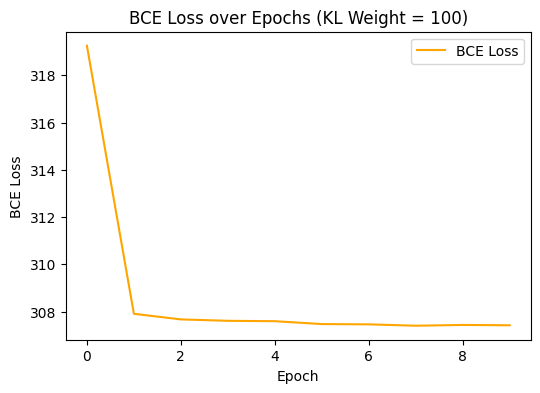

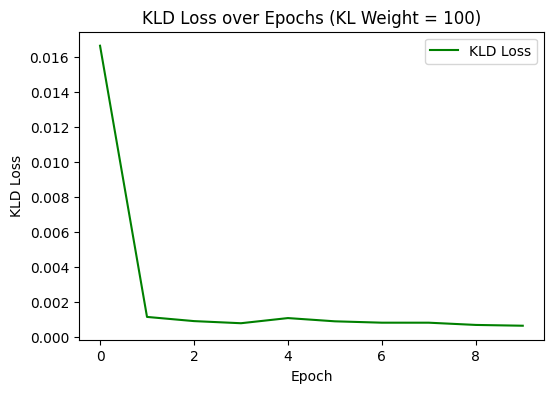

In [13]:
# Hyperparameters
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = CVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    train_losses = []

    av_bce_l = []
    av_kld_l = []
    av_loss_l = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            labels = F.one_hot(labels, num_classes=10).to(device)
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
            
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)

        av_bce_l.append(average_bce)
        av_kld_l.append(average_kld)
        av_loss_l.append(average_loss)
            
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Plot latent space
    plot_latent_space(model, kl_weight)

    plt.figure(figsize=(6, 4))
    plt.plot(av_loss_l, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title(f'Total Loss over Epochs (KL Weight = {kl_weight})')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(av_bce_l, label='BCE Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.title(f'BCE Loss over Epochs (KL Weight = {kl_weight})')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(av_kld_l, label='KLD Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('KLD Loss')
    plt.title(f'KLD Loss over Epochs (KL Weight = {kl_weight})')
    plt.legend()
    plt.show()

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

        data, labels = next(iter(test_loader))
        labels_one_hot = F.one_hot(labels, num_classes=10).to(device)

        data = data.to(device)
        mu, logvar = model.encode(x=data, y=labels_one_hot)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()
        
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

#### Analyse des sorties
Le paramètre $ \beta $ joue un rôle crucial dans la gestion de l'équilibre entre la régularisation de l'espace latent (évaluée par le paramètre KLD) et la fidélité à la reconstruction conditionnée sur les données d'entrée (évaluée par le paramètre BCE). Comme coefficient du premier, il représente la force de la régularisation appliquée à la distribution a priori des variables latentes, ce qui influe la structure et la séparation des différentes classes dans l'espace latent.

Des valeurs de $ \beta $ faibles permettent une plus grande flexibilité dans la représentation des données au sein de l'espace latent, mais risquent d’entraîner un manque de régularisation et de dégrader la séparation des classes. À l'inverse, des valeurs de $ \beta $ élevées contraignent l'espace lattent et le forcent à se rapprocher davantage de la distribution normale standard, ce qui peut entraîner une compression excessive de l'espace latent et une perte de la capacité à distinguer efficacement les différentes classes.


##### Pour $ \beta = 100 $

Dans ce cas, l’espace latent est fortement compressé, et les points de différentes classes sont regroupés très étroitement autour de 0. De plus, les classes ne sont pas géographiquement distingables car très peu separées.

Cela s'explique par le fait que cette grande valeur contraint fortement l’espace latent à prendre la forme d’une distribution gaussienne standard (distribution a priori). Les données sont alors comprimées vers une région centrale, au détriment de la diversité des classes, donc la capacité du modèle à les différencier. En conséquence, la structure des données est moins bien capturée, et la séparation des classes est perdue. La reconstruction des images en est également affectée, car le modèle retient alors moins d’informations pertinentes pour chaque catégorie. 

Un tel choix ne serait pas adapté car les échantillons générés seraient trop similaires, peu diversifiés et flous, avec une faible représentation des différences entre classes, en raison de la forte compression de l’espace latent.


##### Pour $ \beta = 10 $

Dans ce cas, l'espace latent présente une densité plus faible comparée à celle observée pour $ \beta = 100 $. En diminuant la valeur de $ \beta $, la contrainte de régularisation devient moins stricte, permettant ainsi aux points de se disperser davantage dans l'espace latent. Cependant, bien que l’espace latent soit moins contraint, il n'y a toujours pas de séparation nette entre toutes les classes : les points restent relativement mélangés et on ne distingue pas clairement de clusters.

Cette valeur intermédiaire de $ \beta $ montre que le modèle cherche à maintenir un équilibre entre la régularisation et la reconstruction. Les points peuvent occuper une plus grande surface de l’espace latent, mais cette flexibilité n’est pas encore suffisante pour permettre une séparation complète et bien définie des classes.



##### Pour $ \beta = 1 $

Enfin, pour $ \beta = 1 $, l’espace latent présente une dispersion plus large des points, avec certaines classes qui commencent à se séparer clairement. Certaines classes se chevauchent encore, mais des divisions commencent à apparaître. La classe 8 (Bags) est particulièrement bien séparée, tandis que les autres classes restent partiellement mélangées. Cependant, on remarque que les points correspondant à une même classe ont tendance à se regrouper dans des régions similaires de l'espace latent.

Cette situation résulte du relâchement de la contrainte de régularisation, ce qui permet une plus grande flexibilité dans l'exploration de l'espace latent. Bien que la symétrie et le centrage caractéristiques d'une distribution gaussienne standard soient toujours présents, on observe une forte augmentation de la variance dans l'espace latent. Cette configuration favorise le terme de reconstruction, permettant ainsi au modèle d'explorer plus librement les relations entre les données et de mieux capter les structures sous-jacentes.

Ce choix sera bien le mieux adapté : les échantillons seront plus diversifiés et certaines classes seront clairement séparées, avec une fidélité aux structures originales accrues. En particulier, on s'attend à ce que les classes 2 (Pull-Over) et 8 (Bag) soient bien distinguées, et à ce que des confusions demeurent entre les classes 5 (Sandal) et 9 (Ankle-Boots), ainsi qu'entre 0 (T-T-shirt/top) et 4 (Coat).

# V - Test : génération de cinq échantillons par classe grâce à notre CVAE.

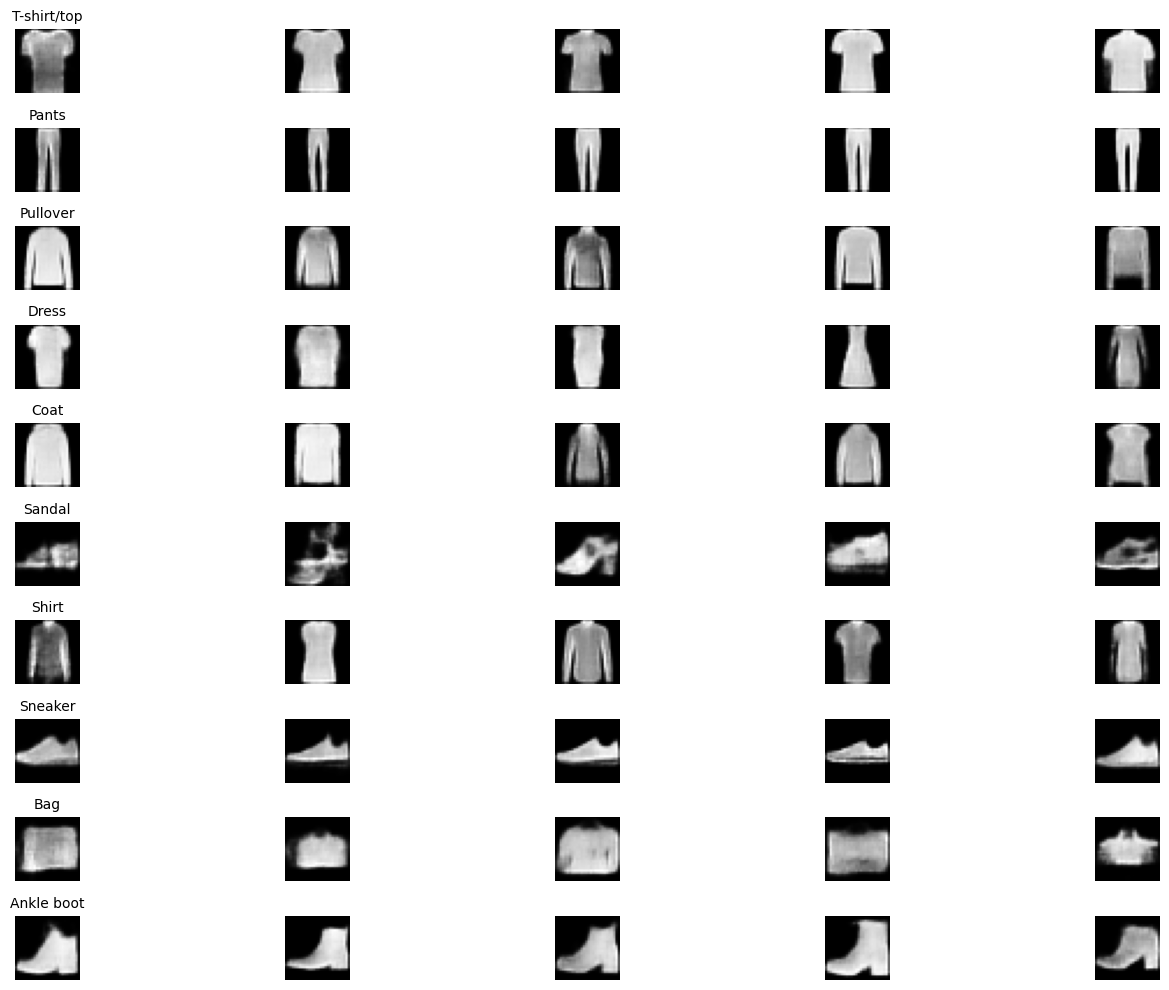

In [11]:
def generate_samples_per_class(num_samples=5):
    """
    Génère `num_samples` images pour chaque classe de Fashion-MNIST.
    """
    cvae.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(10, num_samples, figsize=(15, 10))
        
        # Pour chaque classe (0 à 9 correspondant aux catégories de vêtements)
        for class_idx in range(10):
            # Crée un label one-hot pour la classe en cours
            y = torch.zeros((num_samples, 10), device=device)
            y[:, class_idx] = 1  # Encode la classe actuelle
            
            # Échantillonne aléatoirement `num_samples` vecteurs latents
            z = torch.randn(num_samples, latent_dim).to(device)
            
            # Décode les vecteurs latents conditionnés sur le label de la classe
            samples = cvae.decode(z, y)
            samples = samples.cpu().view(num_samples, 1, 28, 28)
            
            # Affiche les échantillons générés pour cette classe
            for i in range(num_samples):
                axs[class_idx, i].imshow(samples[i].squeeze(0), cmap='gray')
                axs[class_idx, i].axis('off')
                if i == 0:
                    axs[class_idx, i].set_title(fashion_mnist_labels[class_idx], fontsize=10)
    
    plt.tight_layout()
    plt.show()

generate_samples_per_class()


Ces échantillons montrent que le modèle a su capturer les traits distinctifs de chaque classe : les caractéristiques visuelles communes sont présentes dans chaque image. Cependant, il existe aussi une certaine variabilité intra-classe que nous nous étions précedemment permis de questionner. Les images sont clairement distinctes les unes des autres, notamment dans la classe "dress". Cela est bon signe car cela montre que la diversité existantes au sein de chaque catégorie a également été capturée et donc que l'espace latent du modèle est suffisament flexible.

La classe "sandal" semble néanmoins avoir été moins bien capturée : il y a des échecs de génération, par exemple, la deuxième image générée est peu précise et peu reconnaissable par l'oeil humain. Aussi, certaines confusions avec la classe "sneakers" sont présentes. Il en ava de même entre les classes "sandal" et "ankle boots". Ces résultats confirment ce que visualisation de l'espace latent nous avait permis de supposer, voire sont meilleurs sur certaines catégories : il est intéressant de noter que les résultats sur certaines catégories, comme "dress" et "pants" (pantalon), surpassent les attentes, avec une séparation plus nette que ce que suggérait l'analyse de l’espace latent.

En règle générale, les classes semblent en majorité présenter une bonne cohérence intra-classe, une distinction claire entre les classes, des détails visuels nets, et des variations. Nous pouvons donc en être satisfaits.